In [ ]:
pip install torch

In [ ]:
pip install pennylane

In [11]:
import torch
import pennylane as qml
import numpy as np
import math
import matplotlib.pyplot as plt

n_qubits = 12
n_qubits_op = 4
n_rotaciones = (n_qubits_op+1)*n_qubits_op//2

# Especificación del circuito

In [12]:
dev = qml.device("default.qubit", wires=n_qubits)

wires = range(n_qubits)
w_op1 = range(n_qubits_op)
w_op2 = range(n_qubits_op, 2*n_qubits_op)
w_res = range(2*n_qubits_op, n_qubits)

def sumador(weights, op1, op2):
  count = 0
  for i in reversed(range(len(op1))):
    for j in op2[len(op2)-i-1:]:
      qml.CRZ(weights[count], [j, op1[i]])
      count += 1

@qml.qnode(dev)
def circuit(inputs, weights):
  inputs *= math.pi
  qml.AngleEmbedding(inputs, wires=range(n_qubits))
  count = 0
  qml.QFT(wires=w_res)
  for i in range(n_qubits_op):
    for j in range(2**i):
      qml.ctrl(sumador, [w_op2[i]])(weights[count], w_res, w_op1)
      count += 1
  qml.adjoint(qml.QFT(wires=w_res))
  return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

inputs = np.zeros(n_qubits)
weights = np.random.uniform(0., 2*math.pi, (15,n_rotaciones))
print(qml.draw(circuit)(inputs, weights))

 0: ─╭AngleEmbedding(M0)──────╭●───────────────────────────────────────────────────────────────────
 1: ─├AngleEmbedding(M0)──────│─────────╭●────────────────────────────╭●───────────────────────────
 2: ─├AngleEmbedding(M0)──────│─────────│─────────╭●──────────────────│─────────╭●─────────────────
 3: ─├AngleEmbedding(M0)──────│─────────│─────────│─────────╭●────────│─────────│─────────╭●───────
 4: ─├AngleEmbedding(M0)──────├●────────├●────────├●────────├●────────├●────────├●────────├●───────
 5: ─├AngleEmbedding(M0)──────│─────────│─────────│─────────│─────────│─────────│─────────│────────
 6: ─├AngleEmbedding(M0)──────│─────────│─────────│─────────│─────────│─────────│─────────│────────
 7: ─├AngleEmbedding(M0)──────│─────────│─────────│─────────│─────────│─────────│─────────│────────
 8: ─├AngleEmbedding(M0)─╭QFT─│─────────│─────────│─────────│─────────│─────────│─────────│────────
 9: ─├AngleEmbedding(M0)─├QFT─│─────────│─────────│─────────│─────────│─────────│─────────│────────


## Funciones auxiliares

- binarios(x): devuelve la concatenación de las representaciones binarias de los elementos de la lista x.
- formatoSalida(y): dada una lista/tensor 'y' de valores entre -1 y 1, devuelve una lista de sus valores con signo opuesto y acotados al intervalo \[0,1\]
- decimales(y): dada una lista 'y' con la codificación binaria de un número arbitrario de valores de n_qubits//2 bits, devuelve la lista de dichos valores en decimal.

In [13]:
def binarios(x):
  return sum([[int(i) for i in list(('{:0'+str(n_qubits_op)+'b}').format(a))] for a in x], [])

def formatoSalida(y):
  if type(y) == torch.Tensor:
    return -1*(y-1) / 2
  return [abs(round((-1*(x if type(x) != torch.Tensor else x.item())+1)/2, 2)) for x in y]

def decimales(y):
  if type(y) == torch.Tensor:
    y = y.detach().numpy().tolist()
  y = np.split(np.array(y), [n_qubits_op, 2*n_qubits_op])
  return [int("".join(str(int(abs(round(x)))) for x in bits), 2) for bits in y]

In [14]:
formatoSalida(circuit(torch.Tensor(binarios([1,2,0])), weights))

[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.41, 0.89, 0.28, 1.0]

# Conjunto de datos

In [16]:
train_set_mult = []
for x1 in range(2**(n_qubits_op)):
  for x2 in range(1, 2**(n_qubits_op)):
    if x1 * x2 < 2**(n_qubits_op):
      train_set_mult.append((binarios([x1, x2, 0]),binarios([x1, x2, x1*x2])))
print(len(train_set_mult))

60


# Entrenamiento y resultados

In [15]:
def train(model, train_set, epochs=15, lr=0.5):
  opt = torch.optim.SGD(model.parameters(), lr=lr)
  loss = torch.nn.L1Loss()
  avg_loss_list = []
  for epoch in range(epochs):
    running_loss = 0
    for (x,y) in train_set:
        opt.zero_grad()
        x = torch.Tensor(x)
        y = torch.Tensor(y)
        y_pred = formatoSalida(model(x))
        loss_evaluated = loss(y_pred, y)
        loss_evaluated.backward()
        opt.step()
        running_loss += loss_evaluated

    avg_loss = running_loss / len(train_set)
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))
    avg_loss_list.append(avg_loss.item())
  plt.figure()
  plt.title('Pérdida media por época')
  plt.plot(range(epochs), avg_loss_list)

def accuracy(model, train_set):
  x = [a for a,b in train_set]
  y = [b for a,b in train_set]
  y_pred = model(torch.Tensor(x)).detach().numpy().tolist()

  correct = [(-p+1)/2 if p_true else 1-(-p+1)/2 for pred_bits, y_bits in zip(y_pred, y) for p, p_true in zip(pred_bits, y_bits)]
  accuracy = sum(correct) / len(correct)
  for p in model.parameters():
    print('Parameters/pi:', p / math.pi)
  print(f"Accuracy: {accuracy * 100}%")

Average loss over epoch 1: 0.1213
Average loss over epoch 2: 0.1145
Average loss over epoch 3: 0.1061
Average loss over epoch 4: 0.0969
Average loss over epoch 5: 0.0894
Average loss over epoch 6: 0.0830
Average loss over epoch 7: 0.0764
Average loss over epoch 8: 0.0685
Average loss over epoch 9: 0.0600
Average loss over epoch 10: 0.0536
Average loss over epoch 11: 0.0498
Average loss over epoch 12: 0.0469
Average loss over epoch 13: 0.0440
Average loss over epoch 14: 0.0408
Average loss over epoch 15: 0.0368
Average loss over epoch 16: 0.0313
Average loss over epoch 17: 0.0245
Average loss over epoch 18: 0.0178
Average loss over epoch 19: 0.0124
Average loss over epoch 20: 0.0083
Average loss over epoch 21: 0.0055
Average loss over epoch 22: 0.0036
Average loss over epoch 23: 0.0024
Average loss over epoch 24: 0.0016
Average loss over epoch 25: 0.0011
Average loss over epoch 26: 0.0008
Average loss over epoch 27: 0.0005
Average loss over epoch 28: 0.0004
Average loss over epoch 29: 0

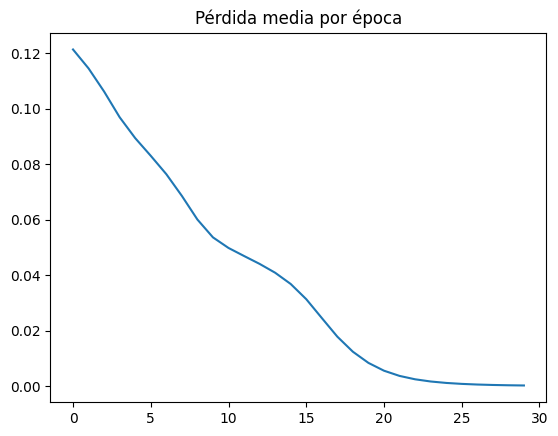

In [23]:
multiplicador = qml.qnn.TorchLayer(circuit, {"weights":(15,n_rotaciones)})

train(multiplicador, train_set_mult, epochs=30)
accuracy(multiplicador, train_set_mult)

In [30]:
print([2,3,0], '->', decimales(formatoSalida(multiplicador(torch.Tensor(binarios([2,3,0]))))))
print([7,2,0], '->', decimales(formatoSalida(multiplicador(torch.Tensor(binarios([7,2,0]))))))
print([14,0,0], '->', decimales(formatoSalida(multiplicador(torch.Tensor(binarios([14,0,0]))))))
print([5,5,0], '->', decimales(formatoSalida(multiplicador(torch.Tensor(binarios([5,5,0]))))))
print([8,10,0], '->', decimales(formatoSalida(multiplicador(torch.Tensor(binarios([8,10,0]))))))

[2, 3, 0] -> [2, 3, 6]
[7, 2, 0] -> [7, 2, 14]
[14, 0, 0] -> [14, 0, 0]
[5, 5, 0] -> [5, 5, 9]
[8, 10, 0] -> [8, 10, 0]
